In [1]:
import os
import sys
import datetime as dt

sys.path.append(r"..")
import pyphenocam
from pyphenocam import plotting
from pyphenocam import imageprocessing

import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pyplot as plt

import numpy as np
import skimage.transform as trans

import skimage

import rasterio

C:\Anaconda\envs\pyphenocam\lib\site-packages\matplotlib\__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
base_dname = r"J:\Projects\NCCSC\phenocam\DerivedData\nationalelkrefuge"
site_name = "nationalelkrefuge"

In [3]:
phenosite = pyphenocam.dataaccess.get_site(site_name)

#### grab a sample_image to use for setting up plots and make a mask of the sky pixels 

In [4]:
closest_date = dt.datetime(2016, 5, 29, 12, 30)
sample_photo_fname = phenosite.get_closest_fname(closest_date)
sample_image = phenosite.get_local_image(sample_photo_fname)

landsat_index_fname = os.path.join(base_dname, "ArcScene", "landsat_subset_index.bmp")
index = skimage.io.imread(landsat_index_fname)
sky = (np.sum(index, axis=2) == 765)
#resize sky to match our sample_image
sky = trans.resize(sky, (sample_image.shape[0], sample_image.shape[1]), preserve_range=True, order=0).astype(np.bool)

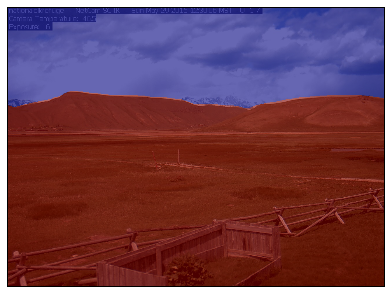

In [5]:
%matplotlib inline
fig, ax = plt.subplots(1, figsize=(12,5))
ax.imshow(sample_image)
ax.imshow(sky, alpha=0.6, cmap=mpl.cm.jet_r)
pyphenocam.plotting.format_photo_axes(ax)

### Functions for plotting landsat

In [6]:
vis_pix_fname = os.path.join(base_dname, "Landsat", "SceneSubset", "mapped", "visible_mask.npy")
visible_pixels = np.load(vis_pix_fname)
visible_pixels = np.ma.MaskedArray(visible_pixels, mask=visible_pixels==0)

template = "LC8038030{}{}LGN00_ndvi.tif"

def landsat_data(lst_date):
    template = "LC8038030{}{}LGN00_ndvi.tif"
    year, month, day = lst_date.year, lst_date.month, lst_date.day

    jday = (dt.datetime(year, month, day) - dt.datetime(year, 1, 1)).days
    fname = os.path.join(base_dname, "Landsat", "SceneSubset", template.format(year, jday))
    
    
    data = rasterio.open(fname).read(1, masked=True)
    cloud_data = rasterio.open(fname.replace('ndvi', 'cloud')).read(1)
    data.mask += cloud_data==4
    return data

def landsat_img(ax, closest_date):
    closest_lst_date = pyphenocam.utils.nearest_date(draped_dates, closest_date) 
    data = landsat_data(closest_lst_date)
    ax.imshow(data, cmap=mpl.cm.YlGn, vmin=0.0, vmax=LANDSAT_MAX, interpolation='none')
    ls_date_title = plotting.add_inner_title(ax, "{dt.month}/{dt.day}/{dt.year}".format(dt=closest_lst_date), 
                                    1, dict(size=20, alpha=0.5))
    ax.imshow(visible_pixels, cmap='jet_r', alpha=0.3, interpolation='none')
    

### Read in the draped landsat images

In [7]:
draped_dname = os.path.join(base_dname, "Landsat", "SceneSubset", "mapped")
draped_fnames = [os.path.join(draped_dname, f) for f in os.listdir(draped_dname)
                if "visible_mask" not in f ]

LANDSAT_MAX = 0.6

def draped_data(closest_date):
    fname = get_closest_landsat_fname(closest_date)
    data = np.load(fname)
    data= np.ma.array(data, mask=data==-255)
    cloudmask = np.ma.copy(data)

    cloudmask[cloudmask==44] = 1
    data.mask += data==44
    return data, cloudmask

def draped_img(ax, closest_date):
    data, cloudmask = draped_data(closest_date)

    im = ax.imshow(data, cmap=mpl.cm.YlGn, vmin=0.0, vmax=LANDSAT_MAX)
    ax.imshow(cloudmask, cmap= mpl.cm.Greys, alpha=0.2, interpolation='none')
    return im
    
def date_from_fname(fname):
    y, m, d = os.path.split(fname)[1].split(".")[0].split("_")[1:]
    year, month, day = [int(s) for s in (y, m, d)]
    return dt.datetime(year, month, day)

def get_closest_landsat_fname(closest_date):
    closest_landsat_date = pyphenocam.utils.nearest_date(draped_dates, closest_date)
    closest_fname = "landsat_{dt.year}_{dt.month:02d}_{dt.day:02d}.npy".format(dt=closest_landsat_date)
    return os.path.join(draped_dname, closest_fname)

draped_dates = [date_from_fname(f) for f in draped_fnames]

### Create the plot that we want to animate

2015-09-03 16:00:00


C:\Anaconda\envs\pyphenocam\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


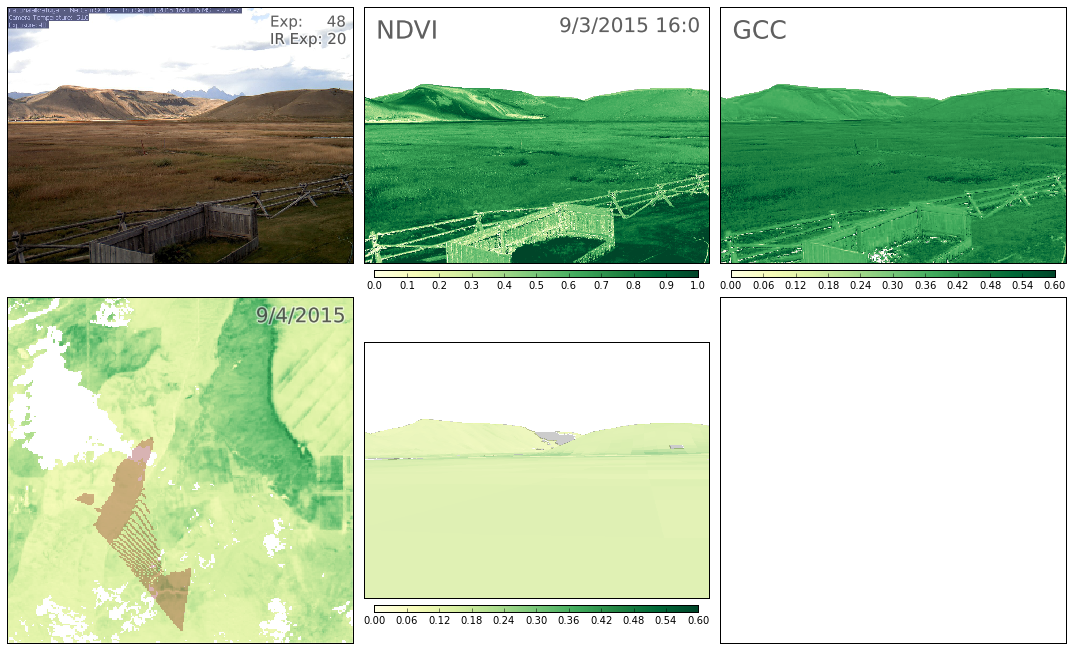

In [8]:
%matplotlib inline


def plot_one(closest_date):
    sample_photo_fname = phenosite.get_closest_fname(closest_date)

    local_fname = phenosite.get_local_image_fname(sample_photo_fname)
    local_fname_ir = phenosite.get_local_image_fname(sample_photo_fname, IR=True)
    sample_image = phenosite.get_local_image(sample_photo_fname)
    sample_image_ir = phenosite.get_local_image(sample_photo_fname, IR=True)

    exposure = pyphenocam.headerextraction.get_exposure(local_fname)
    exposure_ir = pyphenocam.headerextraction.get_exposure(local_fname_ir)

    corrected_ndvi = pyphenocam.imageprocessing._get_corrected_ndvi(local_fname, 
                                                                    local_fname_ir, 
                                                                    float(exposure), 
                                                                    float(exposure_ir))
    corrected_ndvi_m = np.ma.masked_where(sky, corrected_ndvi)

    gcc = imageprocessing.get_gcc(sample_image)
    gcc_m = np.ma.masked_where(sky, gcc)

    fig, ((ax_photo, ax_ndvi, ax_gcc), (ax_landsat, ax_draped, ax_corr)) = plt.subplots(2, 3, 
                                                                                        figsize=(15,10))

    for ax in (ax_photo, ax_ndvi, ax_gcc, ax_landsat, ax_draped, ax_corr):
        plotting.format_photo_axes(ax)

    pyphenocam.plotting.add_inner_title(ax_ndvi, "NDVI", 
                                        2, font_kwargs=dict(size=25, alpha=0.5))
    pyphenocam.plotting.add_inner_title(ax_gcc, "GCC", 
                                        2, font_kwargs=dict(size=25, alpha=0.5))

    exp_title = plotting.add_inner_title(ax_photo, "Exp:     {}\nIR Exp: {}".format(exposure, exposure_ir), 
                                        1, dict(size=15, alpha=0.5))
    date_title = plotting.add_inner_title(ax_ndvi, "{dt.month}/{dt.day}/{dt.year} {dt.hour}:{dt.minute}".format(dt=closest_date), 
                                        1, dict(size=20, alpha=0.5))

    im_photo = ax_photo.imshow(sample_image)
    im_ndvi = ax_ndvi.imshow(corrected_ndvi_m, vmin=0, vmax=1.0, cmap=mpl.cm.YlGn)
    im_gcc = ax_gcc.imshow(gcc_m, vmin=0, vmax=LANDSAT_MAX, cmap=mpl.cm.YlGn)

    plt.tight_layout()
    plotting.bottom_align_cb(ax_ndvi, im_ndvi, height=0.01, yoffset=0.055)
    plotting.bottom_align_cb(ax_gcc, im_gcc, height=0.01, yoffset=0.055)


    landsat_img(ax_landsat, closest_date)

    im_draped = draped_img(ax_draped, closest_date)
    plotting.bottom_align_cb(ax_draped, im_draped, height=0.01, yoffset=0.055)
  

closest_date = dt.datetime(2015, 9, 3, 16, 0)
print closest_date

plot_one(closest_date)

2015-09-04 16:00:00


(<matplotlib.figure.Figure at 0x2851aeb8>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x283a6128>,
  <matplotlib.axes._subplots.AxesSubplot at 0x2812bd68>))

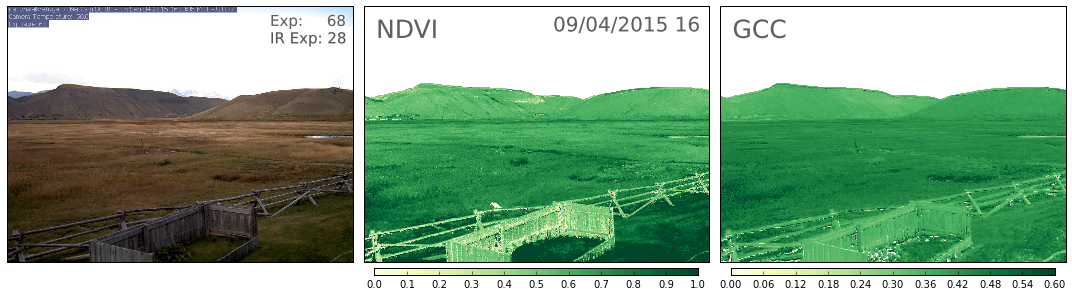

In [9]:
%matplotlib inline


def plot_one_no_landsat(closest_date, fig=None, axes=None):
    sample_photo_fname = phenosite.get_closest_fname(closest_date)

    local_fname = phenosite.get_local_image_fname(sample_photo_fname)
    local_fname_ir = phenosite.get_local_image_fname(sample_photo_fname, IR=True)
    sample_image = phenosite.get_local_image(sample_photo_fname)
    sample_image_ir = phenosite.get_local_image(sample_photo_fname, IR=True)

    exposure = pyphenocam.headerextraction.get_exposure(local_fname)
    exposure_ir = pyphenocam.headerextraction.get_exposure(local_fname_ir)

    corrected_ndvi = pyphenocam.imageprocessing._get_corrected_ndvi(local_fname, 
                                                                    local_fname_ir, 
                                                                    float(exposure), 
                                                                    float(exposure_ir))
    corrected_ndvi_m = np.ma.masked_where(sky, corrected_ndvi)

    gcc = imageprocessing.get_gcc(sample_image)
    gcc_m = np.ma.masked_where(sky, gcc)

    if not fig:
        new_fig = True
        fig = plt.figure(figsize=(15, 5))
        
        ax_photo = fig.add_subplot(131)
        ax_ndvi = fig.add_subplot(132)
        ax_gcc = fig.add_subplot(133)

        for ax in (ax_photo, ax_ndvi, ax_gcc):
            plotting.format_photo_axes(ax)
    else:
        new_fig = False
        (ax_photo, ax_ndvi, ax_gcc) = axes

    pyphenocam.plotting.add_inner_title(ax_ndvi, "NDVI", 
                                        2, font_kwargs=dict(size=25, alpha=0.5))
    pyphenocam.plotting.add_inner_title(ax_gcc, "GCC", 
                                        2, font_kwargs=dict(size=25, alpha=0.5))

    exp_title = plotting.add_inner_title(ax_photo, "Exp:     {:02d}\nIR Exp: {:02d}".format(int(exposure), int(exposure_ir)), 
                                        1, dict(size=15, alpha=0.5))
    date_title = plotting.add_inner_title(ax_ndvi, "{dt.month:02d}/{dt.day:02d}/{dt.year} {dt.hour:02d}".format(dt=closest_date), 
                                        1, dict(size=20, alpha=0.5))

    im_photo = ax_photo.imshow(sample_image)
    im_ndvi = ax_ndvi.imshow(corrected_ndvi_m, vmin=0, vmax=1.0, cmap=mpl.cm.YlGn)
    im_gcc = ax_gcc.imshow(gcc_m, vmin=0, vmax=LANDSAT_MAX, cmap=mpl.cm.YlGn)

    
    
    if new_fig:
        plt.tight_layout()
        plotting.bottom_align_cb(ax_ndvi, im_ndvi, height=0.02, yoffset=0.08)
        plotting.bottom_align_cb(ax_gcc, im_gcc, height=0.02, yoffset=0.08)
    return fig, (ax_photo, ax_ndvi, ax_gcc)

#     landsat_img(ax_landsat, closest_date)

#     im_draped = draped_img(ax_draped, closest_date)
#     plotting.bottom_align_cb(ax_draped, im_draped, height=0.01, yoffset=0.055)
  

closest_date = dt.datetime(2015, 9, 4, 16, 0)
print closest_date

plot_one_no_landsat(closest_date)

2015
	8











		12   hour: 9 . . 10 . . 11 . . 12 . . 13 . . 14 . . 15 . . 
		13   hour: 9 . . 10 . . 11 . . 12 . . 13 . . 14 . . 15 . . 
		14   hour: 9 . . 10 . . 11 . . 12 . . 13 . . 14 . . 15 . . 
		15   hour: 9 . . 10 . . 11 . . 12 . . 13 . . 14 . . 15 . . 
		16   hour: 9 . . 10 . . 11 . . 12 . . 13 . . 14 . . 15 . . 
		17   hour: 9 . . 10 . . 11 . . 12 . . 13 . . 14 . . 15 . . 
		18   hour: 9 . . 10 . . 11 . . 12 . . 13 . . 14 . . 15 . . 
		19   hour: 9 . . 10 . . 11 . . 12 . . 13 . . 14 . . 15 . . 
		20   hour: 9 . . 10 . . 11 . . 12 . . 13 . . 14 . . 15 . . 
		21   hour: 9 . . 10 . . 11 . . 12 . . 13 . . 14 . . 15 . . 
		22   hour: 9 . . 10 . . 11 . . 12 . . 13 . . 14 . . 15 . . 
		23   hour: 9 . . 10 . . 11 . . 12 . . 13 . . 14 . . 15 . . 
		24   hour: 9 . . 10 . . 11 . . 12 . . 13 . . 14 . . 15 . . 
		25   hour: 9 . . 10 . . 11 . . 12 . . 13 . . 14 . . 15 . . 
		26   hour: 9 . . 10 . . 11 . . 12 . . 13 . . 14 . . 15 . . 
		27   hour: 9 . . 10 . . 11 . . 12 . . 13 . . 14 .

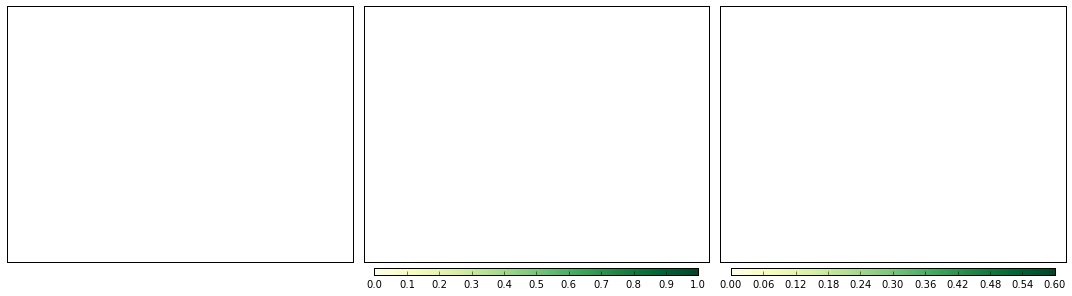

In [11]:
import matplotlib.animation as manimation

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='test', artist='Matplotlib',
                comment='test2')
writer = FFMpegWriter(fps=27, bitrate=5000, metadata=metadata)

fig, axes = plot_one_no_landsat(closest_date)

with writer.saving(fig, os.path.join(base_dname, 'natelk_ndvi_gcc.mp4'), 100):
    years = phenosite.data.keys()
    years.sort()
    for year in years:
        print year
        months = phenosite.data[year].keys()
        months.sort()
        for month in months:
            print '\t', month
            if not phenosite.data[year][month]:
                mdate = dt.datetime(year, month, 1, 12, 30)
                phenosite.data[year][month] = phenosite.get_days(mdate)

            days = phenosite.data[year][month].keys()
            days.sort()
            for day in days:
                if phenosite.data[year][month][day] > 0:
                    print '\t\t', day, '  hour:',
                    for hour in range(9, 16):
                        print hour,
                        for minute in [0, 30]:
                            print ".",
                            closest_date = dt.datetime(year, month, day, hour, minute)
                            try:
                                fig, axes = plot_one_no_landsat(closest_date, fig, axes)
                                writer.grab_frame()
                                for ax in axes:
                                    ax.cla()
                            except:
                                print "<<<fail>>>"
                print ''
print "all done"

# Data check

In [42]:
import cartopy
import cartopy.crs as ccrs

index_grid = skimage.io.imread(landsat_index_fname)
index_grid = trans.resize(index_grid, (sample_image.shape[0], sample_image.shape[1], 3), preserve_range=True, order=0)

index_grid = np.ma.masked_where(index_grid > 254, index_grid)


lst_date = pyphenocam.utils.nearest_date(draped_dates, closest_date)
year, month, day = lst_date.year, lst_date.month, lst_date.day
jday = (dt.datetime(year, month, day) - dt.datetime(year, 1, 1)).days
fname = os.path.join(base_dname, "Landsat", "SceneSubset", template.format(year, jday))
landsat = rasterio.open(fname)
landsat_pixel_data = landsat.read(1, masked=True)

geodetic = ccrs.Geodetic()
ax_proj = ccrs.LambertConformal()
landsat_proj = ccrs.UTM(zone=12, globe=ccrs.Globe(datum='WGS84',
                                              ellipse='WGS84'))
ax_extent = [phenosite.x - 0.02, phenosite.x + 0.02, phenosite.y - 0.002, phenosite.y + 0.040]

landsat_extents = [landsat.bounds.left, landsat.bounds.right, landsat.bounds.bottom, landsat.bounds.top]


drapped_landsat_data, _ = draped_data(closest_date)

<IPython.core.display.Javascript object>


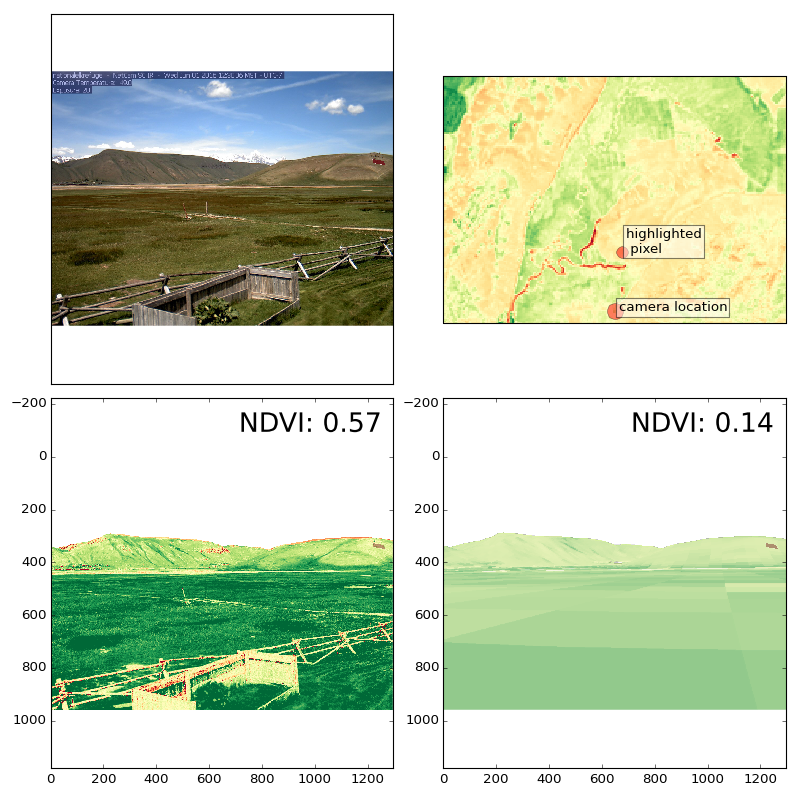

In [44]:
%matplotlib notebook
from ipywidgets import interactive

col_index, row_index = 0,0
#col_index=127, row_index=250
def plot_one(col_index=132, row_index=207):
    single_pixel = np.logical_and(index_grid[:,:,0]==col_index, index_grid[:,:,1]==row_index)

    single_pixel = np.ma.asarray(trans.resize(single_pixel, 
                (sample_image.shape[0], sample_image.shape[1]), preserve_range=False))#[:,:,1]

    single_pixel.mask = single_pixel==False

    fig = plt.figure(figsize=(10, 10))
    ax = plt.subplot(221)
    ax.imshow(sample_image)
    ax.imshow(single_pixel, alpha = 0.75, cmap=mpl.cm.Reds, interpolation='none')
    pyphenocam.plotting.format_photo_axes(ax)

    ax_proj = landsat_proj
    ax2 = plt.subplot(222, projection=ax_proj)
    ax_extent = [phenosite.x - 0.04, phenosite.x + 0.04, phenosite.y - 0.002, phenosite.y + 0.040]
    ax2.set_extent(ax_extent, ccrs.Geodetic())
    ax2.imshow(landsat_pixel_data, origin='upper', extent=landsat_extents, transform=landsat_proj, interpolation='none', 
          cmap=mpl.cm.RdYlGn)
    colx, coly = landsat.affine * (col_index, row_index)
    colx += landsat.transform[1]/2.
    coly += landsat.transform[5]/2.
    
    colxgeo, colygeo = list(ax_proj.transform_point(colx, coly, landsat_proj))
    ax2.plot(colxgeo, colygeo, 'bo', markersize=10, color='red', alpha=0.5)
    ax2.text(colxgeo+75, colygeo-15, 'highlighted \n pixel', bbox={'facecolor':'white', 'alpha':0.5, 'pad':5})

    # mark a known place to help us geo-locate ourselves
    locx, locy = list(ax_proj.transform_point(phenosite.x, phenosite.y, geodetic))
    ax2.plot(locx, locy, 'bo', markersize=15, color='red', alpha=0.5)
    ax2.text(locx+75, locy-10, 'camera location', bbox={'facecolor':'white', 'alpha':0.5, 'pad':5})

    ax_ndvi = fig.add_subplot(223, sharex=ax, sharey=ax)
    ax_draped = fig.add_subplot(224, sharex=ax, sharey=ax)
#     ax3.set_xlabel('X')
#     ax3.set_ylabel('Y')
#     ax3.set_zlabel('elev')

#     plot_3d_slope(row_index, col_index, ax3, fall_line=True)

#     set_aspect_equal_3d(ax3)
    im_ndvi = ax_ndvi.imshow(corrected_ndvi_m, vmin=0, vmax=1.0, cmap=mpl.cm.RdYlGn, interpolation='none')

    im_ndvi = ax_ndvi.imshow(single_pixel, alpha=0.4, cmap=mpl.cm.Reds, interpolation='none')
    
    im_draped = draped_img(ax_draped, closest_date)
    try:
        plotting.add_inner_title(ax_ndvi, "NDVI: {:.2f}".format(corrected_ndvi_m[single_pixel==True].mean()),
                      font_kwargs=dict(size=24))
        plotting.add_inner_title(ax_draped, "NDVI: {:.2f}".format(drapped_landsat_data[single_pixel==True].mean()),
                      font_kwargs=dict(size=24))
    except:
        pass
    ax_draped.imshow(single_pixel, alpha = 0.4, cmap=mpl.cm.Reds, interpolation='none')
    plt.tight_layout()
    
    plotting.bottom_align_cb(ax_ndvi, im_ndvi, height=0.02, yoffset=-0.08, shrink=0.07)
    plotting.bottom_align_cb(ax_draped, im_draped, height=0.02, yoffset=-0.08, shrink=0.07)

interactive(plot_one, col_index=(0, landsat.shape[0], 1), row_index=(0, landsat.shape[1], 1))

In [29]:
with writer.saving(fig, os.path.join(base_dname, 'natelk.mp4'), 100):
    for month in range(2, 6):
        print month
        for day in range(1, 32):
            print ""
            print '\t', day, '\t',
            for hour in range(9, 16):
                print hour,
                for minute in [0, 30]:
                    print ".",
                    try:
                        closest_date = dt.datetime(2016, month, day, hour, minute)
                        sample_photo_fname = phenosite.get_closest_fname(closest_date)

                        local_fname = phenosite.get_local_image_fname(sample_photo_fname)
                        local_fname_ir = phenosite.get_local_image_fname(sample_photo_fname, IR=True)
                        sample_image = phenosite.get_local_image(sample_photo_fname)
                        sample_image_ir = phenosite.get_local_image(sample_photo_fname, IR=True)

                        exposure = pyphenocam.headerextraction.get_exposure(local_fname)
                        exposure_ir = pyphenocam.headerextraction.get_exposure(local_fname_ir)
                        corrected_ndvi = pyphenocam.imageprocessing._get_corrected_ndvi(local_fname, 
                                                                                        local_fname_ir, 
                                                                                        float(exposure), 
                                                                                        float(exposure_ir))
                        corrected_ndvi_m = np.ma.masked_where(sky, corrected_ndvi)

                        im_photo = ax_photo.imshow(sample_image)
                        im_ndvi = ax_ndvi.imshow(corrected_ndvi_m, vmin=0, vmax=1., cmap=mpl.cm.RdYlGn)
                        im_gcc = ax_gcc.imshow(gcc(sample_image), vmin=0, vmax=0.5, cmap=mpl.cm.RdYlGn)

                        date_title.txt.set_text("{dt.month}/{dt.day}/{dt.year} {dt.hour:02d}:{dt.minute:02d}".format(dt=closest_date))
                        exp_title.txt.set_text("Exp:     {}\nIR Exp: {}".format(exposure, exposure_ir))
                        
                        writer.grab_frame()
                        im_photo.remove()
                        im_ndvi.remove()
                        im_gcc.remove()
                        
                        del im_photo
                        del im_ndvi
                        del im_gcc
                        
                        del sample_image
                        del corrected_ndvi
                        del corrected_ndvi_m
                        del sample_image_ir
                    except Exception, e:
                        print "except:", str(e)
                        try:
                            del im
                            del im2
                            del sample_image
                            del corrected_ndvi
                            del corrected_ndvi_m
                            del sample_image_ir
                        except:
                            pass

NameError: name 'writer' is not defined

2016-05-29 12:30:00


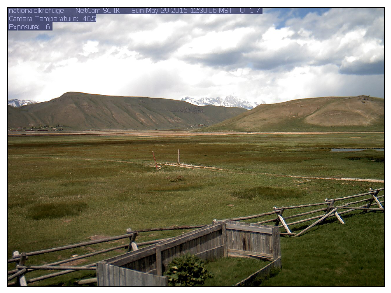

In [4]:
%matplotlib inline
landsat_fishnet_fname = os.path.join(base_dname, "ArcScene", "landsat_fishnet.bmp")
landsat_index_fname = os.path.join(base_dname, "ArcScene", "landsat_subset_index.bmp")

phenosite = pyphenocam.dataaccess.get_site(site_name)

closest_date = dt.datetime(2016, 5, 29, 12, 30)
print closest_date
sample_photo_fname = phenosite.get_closest_fname(closest_date)

local_fname = phenosite.get_local_image_fname(sample_photo_fname)
local_fname_ir = phenosite.get_local_image_fname(sample_photo_fname, IR=True)
sample_image = phenosite.get_local_image(sample_photo_fname)
sample_image_ir = phenosite.get_local_image(sample_photo_fname, IR=True)

fig, ax = plt.subplots(1, figsize=(12,5))
ax.imshow(sample_image)
pyphenocam.plotting.format_photo_axes(ax)

In [5]:

index = skimage.io.imread(landsat_index_fname)
sky = (np.sum(index, axis=2) == 765)
#resize sky to match our sample_image
sky = trans.resize(sky, (sample_image.shape[0], sample_image.shape[1]), preserve_range=True, order=0).astype(np.bool)

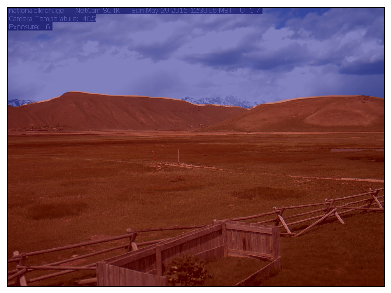

In [6]:
fig, ax = plt.subplots(1, figsize=(12,5))
ax.imshow(sample_image)
ax.imshow(sky, alpha=0.5, cmap=mpl.cm.jet_r)
pyphenocam.plotting.format_photo_axes(ax)

In [7]:
def get_bluesky(sample_image, sky):
    blue = sample_image[:,:,2] / np.sum(sample_image, axis=2).astype(np.float32)
    pcnt_bluesky = 1 - np.mean(sample_image[sky][:, 2])/255.
    return pcnt_bluesky

2016-05-29 12:30:00
0.142305231826


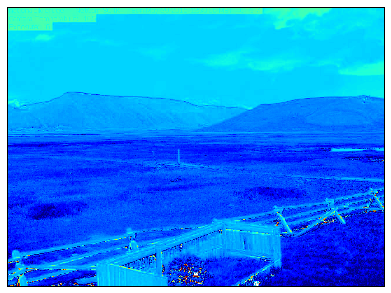

In [8]:
closest_date = dt.datetime(2016, 5, 29, 12, 30)
print closest_date
sample_photo_fname = phenosite.get_closest_fname(closest_date)

local_fname = phenosite.get_local_image_fname(sample_photo_fname)
local_fname_ir = phenosite.get_local_image_fname(sample_photo_fname, IR=True)
sample_image = phenosite.get_local_image(sample_photo_fname)
sample_image_ir = phenosite.get_local_image(sample_photo_fname, IR=True)

fig, ax = plt.subplots(1, figsize=(12,5))
# ax.imshow(sample_image)
blue = sample_image[:,:,2] / np.sum(sample_image, axis=2).astype(np.float32)
ax.imshow(blue)
pyphenocam.plotting.format_photo_axes(ax)
print get_bluesky(sample_image, sky)

2015-09-01 12:30:00
0.396863235732


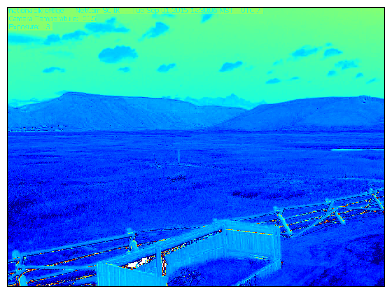

In [9]:
closest_date = dt.datetime(2015, 9, 1, 12, 30)
print closest_date
sample_photo_fname = phenosite.get_closest_fname(closest_date)

local_fname = phenosite.get_local_image_fname(sample_photo_fname)
local_fname_ir = phenosite.get_local_image_fname(sample_photo_fname, IR=True)
sample_image = phenosite.get_local_image(sample_photo_fname)
sample_image_ir = phenosite.get_local_image(sample_photo_fname, IR=True)

fig, ax = plt.subplots(1, figsize=(12,5))
# ax.imshow(sample_image)
blue = sample_image[:,:,2] / np.sum(sample_image, axis=2).astype(np.float32)
ax.imshow(blue)
pyphenocam.plotting.format_photo_axes(ax)

print get_bluesky(sample_image, sky)

2015-10-01 12:30:00
0.23062210802


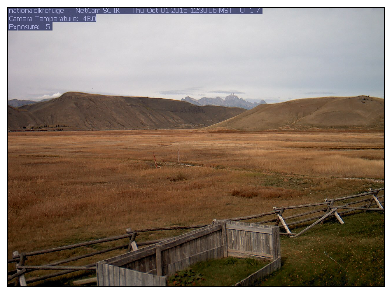

In [14]:
closest_date = dt.datetime(2015, 10, 1, 12, 30)
print closest_date
sample_photo_fname = phenosite.get_closest_fname(closest_date)

local_fname = phenosite.get_local_image_fname(sample_photo_fname)
local_fname_ir = phenosite.get_local_image_fname(sample_photo_fname, IR=True)
sample_image = phenosite.get_local_image(sample_photo_fname)
sample_image_ir = phenosite.get_local_image(sample_photo_fname, IR=True)

fig, ax = plt.subplots(1, figsize=(12,5))
ax.imshow(sample_image)
pyphenocam.plotting.format_photo_axes(ax)

print get_bluesky(sample_image, sky)

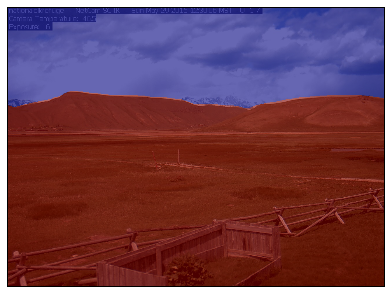

In [12]:
ax.get_figure()

In [15]:
def gcc(img):
    gcc = img[:,:, 0].astype(np.float32) / np.sum(img, axis=2)
    return np.ma.masked_where(sky, gcc)

In [16]:
def bottom_align_cb(fig, ax, im, height=0.02, shrink=0.01, yoffset=0.08):
    b = ax.get_position()
    b.x0, b.width
    cax = fig.add_axes([b.x0 + shrink, b.y0 + yoffset, 
                            b.width - (shrink * 2), height])
    fig.colorbar(im, cax=cax, orientation='horizontal')
    return cax

2016-06-01 12:30:00


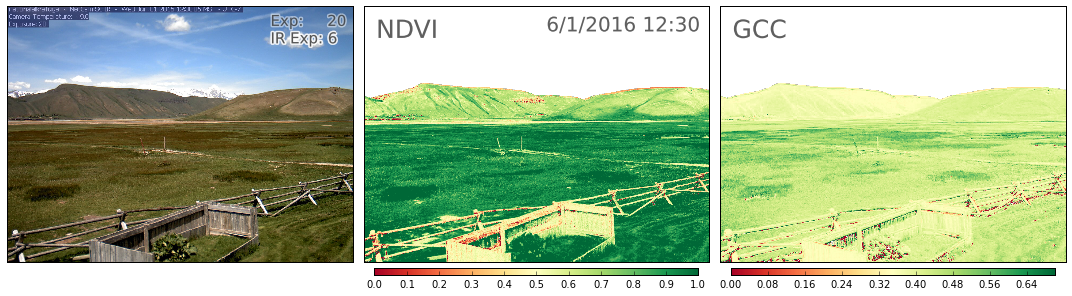

In [22]:
closest_date = dt.datetime(2016, 6, 1, 12, 30)
print closest_date
sample_photo_fname = phenosite.get_closest_fname(closest_date)

local_fname = phenosite.get_local_image_fname(sample_photo_fname)
local_fname_ir = phenosite.get_local_image_fname(sample_photo_fname, IR=True)
sample_image = phenosite.get_local_image(sample_photo_fname)
sample_image_ir = phenosite.get_local_image(sample_photo_fname, IR=True)

exposure = pyphenocam.headerextraction.get_exposure(local_fname)
exposure_ir = pyphenocam.headerextraction.get_exposure(local_fname_ir)

corrected_ndvi = pyphenocam.imageprocessing._get_corrected_ndvi(local_fname, 
                                                                local_fname_ir, 
                                                                float(exposure), 
                                                                float(exposure_ir))
corrected_ndvi_m = np.ma.masked_where(sky, corrected_ndvi)

fig, (ax_photo, ax_ndvi, ax_gcc) = plt.subplots(1, 3, figsize=(15,5))
pyphenocam.plotting.format_photo_axes(ax_photo)
pyphenocam.plotting.format_photo_axes(ax_ndvi)
pyphenocam.plotting.format_photo_axes(ax_gcc)

pyphenocam.plotting.add_inner_title(ax_ndvi, "NDVI", 
                                    2, dict(size=25, alpha=0.5))
pyphenocam.plotting.add_inner_title(ax_gcc, "GCC", 
                                    2, dict(size=25, alpha=0.5))

exp_title = pyphenocam.plotting.add_inner_title(ax_photo, "Exp:     {}\nIR Exp: {}".format(exposure, exposure_ir), 
                                    1, dict(size=15, alpha=0.5))
date_title = pyphenocam.plotting.add_inner_title(ax_ndvi, "{dt.month}/{dt.day}/{dt.year} {dt.hour}:{dt.minute}".format(dt=closest_date), 
                                    1, dict(size=20, alpha=0.5))

im_photo = ax_photo.imshow(sample_image)
im_ndvi = ax_ndvi.imshow(corrected_ndvi_m, vmin=0, vmax=1.0, cmap=mpl.cm.RdYlGn)
im_gcc = ax_gcc.imshow(gcc(sample_image), vmin=0, vmax=0.7, cmap=mpl.cm.RdYlGn)

plt.tight_layout()
bottom_align_cb(fig, ax_ndvi, im_ndvi)
bottom_align_cb(fig, ax_gcc, im_gcc)



2

	1 	9 . . 10 . . 11 . . 12 . . 13 . . 14 . . 15 . . 
	2 	9 . . 10 . . 11 . . 12 . . 13 . . 14 . . 15 . . 
	3 	9 . . 10 . . 11 . . 12 . . 13 . . 14 . . 15 . . 
	4 	9 . . 10 . . 11 . . 12 . . 13 . . 14 . . 15 . . 
	5 	9 . . 10 . . 11 . . 12 . . 13 . . 14 . . 15 . . 
	6 	9 . . 10 . . 11 . . 12 . . 13 . . 14 . . 15 . . 
	7 	9 . . 10 . . 11 . . 12 . . 13 . . 14 . . 15 . . 
	8 	9 . . 10 . . 11 . . 12 . . 13 . . 14 . . 15 . . 
	9 	9 . . 10 . . 11 . . 12 . . 13 . . 14 . . 15 . . 
	10 	9 . . 10 . . 11 . . 12 . . 13 . . 14 . . 15 . . 
	11 	9 . . 10 . . 11 . . 12 . . 13 . . 14 . . 15 . . 
	12 	9 . . 10 . . 11 . . 12 . . 13 . . 14 . . 15 . . 
	13 	9 . . 10 . . 11 . . 12 . . 13 . . 14 . . 15 . . 
	14 	9 . . 10 . . 11 . . 12 . . 13 . . 14 . . 15 . . 
	15 	9 . . 10 . . 11 . . 12 . . 13 . . 14 . . 15 . . 
	16 	9 . . 10 . . 11 . . 12 . . 13 . . 14 . . 15 . . 
	17 	9 . . 10 . . 11 . . 12 . . 13 . . 14 . . 15 . . 
	18 	9 . . 10 . . 11 . . 12 . . 13 . . 14 . . 15 . . 
	19 	9 . . 10 . . 11 . . 12 . . 13

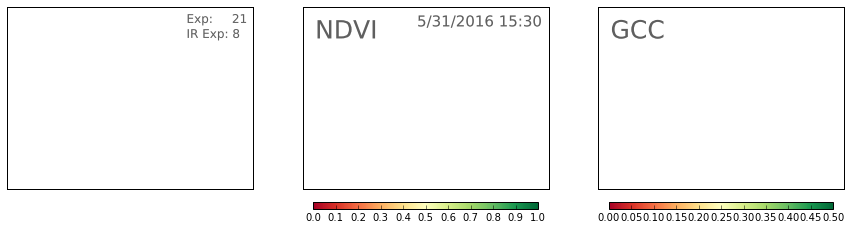

In [18]:
# This example uses a MovieWriter directly to grab individual frames and
# write them to a file. This avoids any event loop integration, but has
# the advantage of working with even the Agg backend. This is not recommended
# for use in an interactive setting.
# -*- noplot -*-

import numpy as np
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.animation as manimation

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='test', artist='Matplotlib',
                comment='test2')
writer = FFMpegWriter(fps=10, bitrate=5000, metadata=metadata)

fig, (ax_photo, ax_ndvi, ax_gcc) = plt.subplots(1, 3, figsize=(15,5))
pyphenocam.plotting.format_photo_axes(ax_photo)
pyphenocam.plotting.format_photo_axes(ax_ndvi)
pyphenocam.plotting.format_photo_axes(ax_gcc)

pyphenocam.plotting.add_inner_title(ax_ndvi, "NDVI", 
                                    2, dict(size=25, alpha=0.5))
pyphenocam.plotting.add_inner_title(ax_gcc, "GCC", 
                                    2, dict(size=25, alpha=0.5))

exp_title = pyphenocam.plotting.add_inner_title(ax_photo, "Exp:     {}\nIR Exp: {}".format(exposure, exposure_ir), 
                                    1, dict(size=12, alpha=0.5))
date_title = pyphenocam.plotting.add_inner_title(ax_ndvi, "{dt.month}/{dt.day}/{dt.year} {dt.hour}:{dt.minute}".format(dt=closest_date), 
                                    1, dict(size=15, alpha=0.5))

bottom_align_cb(fig, ax_ndvi, im_ndvi)
bottom_align_cb(fig, ax_gcc, im_gcc)

with writer.saving(fig, os.path.join(base_dname, 'natelk.mp4'), 100):
    for month in range(2, 6):
        print month
        for day in range(1, 32):
            print ""
            print '\t', day, '\t',
            for hour in range(9, 16):
                print hour,
                for minute in [0, 30]:
                    print ".",
                    try:
                        closest_date = dt.datetime(2016, month, day, hour, minute)
                        sample_photo_fname = phenosite.get_closest_fname(closest_date)

                        local_fname = phenosite.get_local_image_fname(sample_photo_fname)
                        local_fname_ir = phenosite.get_local_image_fname(sample_photo_fname, IR=True)
                        sample_image = phenosite.get_local_image(sample_photo_fname)
                        sample_image_ir = phenosite.get_local_image(sample_photo_fname, IR=True)

                        exposure = pyphenocam.headerextraction.get_exposure(local_fname)
                        exposure_ir = pyphenocam.headerextraction.get_exposure(local_fname_ir)
                        corrected_ndvi = pyphenocam.imageprocessing._get_corrected_ndvi(local_fname, 
                                                                                        local_fname_ir, 
                                                                                        float(exposure), 
                                                                                        float(exposure_ir))
                        corrected_ndvi_m = np.ma.masked_where(sky, corrected_ndvi)

                        im_photo = ax_photo.imshow(sample_image)
                        im_ndvi = ax_ndvi.imshow(corrected_ndvi_m, vmin=0, vmax=1., cmap=mpl.cm.RdYlGn)
                        im_gcc = ax_gcc.imshow(gcc(sample_image), vmin=0, vmax=0.5, cmap=mpl.cm.RdYlGn)

                        date_title.txt.set_text("{dt.month}/{dt.day}/{dt.year} {dt.hour:02d}:{dt.minute:02d}".format(dt=closest_date))
                        exp_title.txt.set_text("Exp:     {}\nIR Exp: {}".format(exposure, exposure_ir))
                        
                        writer.grab_frame()
                        im_photo.remove()
                        im_ndvi.remove()
                        im_gcc.remove()
                        
                        del im_photo
                        del im_ndvi
                        del im_gcc
                        
                        del sample_image
                        del corrected_ndvi
                        del corrected_ndvi_m
                        del sample_image_ir
                    except Exception, e:
                        print "except:", str(e)
                        try:
                            del im
                            del im2
                            del sample_image
                            del corrected_ndvi
                            del corrected_ndvi_m
                            del sample_image_ir
                        except:
                            pass


In [ ]:
# This example uses a MovieWriter directly to grab individual frames and
# write them to a file. This avoids any event loop integration, but has
# the advantage of working with even the Agg backend. This is not recommended
# for use in an interactive setting.
# -*- noplot -*-

import numpy as np
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.animation as manimation

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='test', artist='Matplotlib',
                comment='test2')
writer = FFMpegWriter(fps=2, bitrate=5000, metadata=metadata)

fig, (ax_photo, ax_ndvi, ax_gcc) = plt.subplots(1, 3, figsize=(15,5))
pyphenocam.plotting.format_photo_axes(ax_photo)
pyphenocam.plotting.format_photo_axes(ax_ndvi)
pyphenocam.plotting.format_photo_axes(ax_gcc)

pyphenocam.plotting.add_inner_title(ax_ndvi, "NDVI", 
                                    2, dict(size=25, alpha=0.5))
pyphenocam.plotting.add_inner_title(ax_gcc, "GCC", 
                                    2, dict(size=25, alpha=0.5))

exp_title = pyphenocam.plotting.add_inner_title(ax_photo, "Exp:     {}\nIR Exp: {}".format(exposure, exposure_ir), 
                                    1, dict(size=15, alpha=0.5))
date_title = pyphenocam.plotting.add_inner_title(ax_ndvi, "{dt.month}/{dt.day}/{dt.year} {dt.hour}:{dt.minute}".format(dt=closest_date), 
                                    1, dict(size=20, alpha=0.5))


with writer.saving(fig, r'C:\temp_colin\downloads\Python_exploration\natelk.mp4', 100):
    for month in range(5, 6):
        print month
        for day in range(1, 4):
            print ""
            print '\t', day, '\t',
            for hour in range(9, 15):
                print hour,
                for minute in [0, 30]:
                    print ".",
                    try:
                        closest_date = dt.datetime(2016, month, day, hour, minute)
                        sample_photo_fname = phenosite.get_closest_fname(closest_date)

                        local_fname = phenosite.get_local_image_fname(sample_photo_fname)
                        local_fname_ir = phenosite.get_local_image_fname(sample_photo_fname, IR=True)
                        sample_image = phenosite.get_local_image(sample_photo_fname)
                        sample_image_ir = phenosite.get_local_image(sample_photo_fname, IR=True)

                        exposure = pyphenocam.headerextraction.get_exposure(local_fname)
                        exposure_ir = pyphenocam.headerextraction.get_exposure(local_fname_ir)
                        corrected_ndvi = pyphenocam.imageprocessing._get_corrected_ndvi(local_fname, 
                                                                                        local_fname_ir, 
                                                                                        float(exposure), 
                                                                                        float(exposure_ir))
                        corrected_ndvi_m = np.ma.masked_where(sky, corrected_ndvi)

                        im_photo = ax_photo.imshow(sample_image)
                        im_ndvi = ax_ndvi.imshow(corrected_ndvi_m, vmin=0, vmax=1., cmap=mpl.cm.RdYlGn)
                        im_gcc = ax_gcc.imshow(gcc(sample_image), vmin=0, vmax=0.5, cmap=mpl.cm.RdYlGn)
                        plt.tight_layout()

                       
                        
                        
                        del im
                        del im2
                        del sample_image
                        del corrected_ndvi
                        del corrected_ndvi_m
                        del sample_image_ir
                    except:
                        try:
                            del im
                            del im2
                            del sample_image
                            del corrected_ndvi
                            del corrected_ndvi_m
                            del sample_image_ir
                        except:
                            pass